In [1]:
import numpy as np
from sklearn import ensemble
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import seaborn as sns
import pickle
from scipy.stats import boxcox
from mpl_toolkits.mplot3d import Axes3D



In [2]:
# #############################################################################
# Real benchmarked dataset
#data = pd.read_csv('../../RealData/RealData_nginx_small.csv')
data = pd.read_csv('../../RealData/RealData_haproxy_big.csv')

## Log Syn. Data
#data = pd.read_csv('../../SynData/data/GeneratedLogData.csv')




   Unnamed: 0  CPU  throughput
0           0  0.1    49192.75
1           1  0.1    50082.85
2           2  0.1    49936.27
3           3  0.1    49879.74
4           4  0.1    47800.17
       Unnamed: 0         CPU     throughput
count    800.0000  800.000000     800.000000
mean     399.5000    0.550000  391121.643500
std      231.0844    0.287408  223930.035609
min        0.0000    0.100000   47112.290000
25%      199.7500    0.300000  202593.722500
50%      399.5000    0.550000  367637.085000
75%      599.2500    0.800000  581665.452500
max      799.0000    1.000000  786490.510000


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


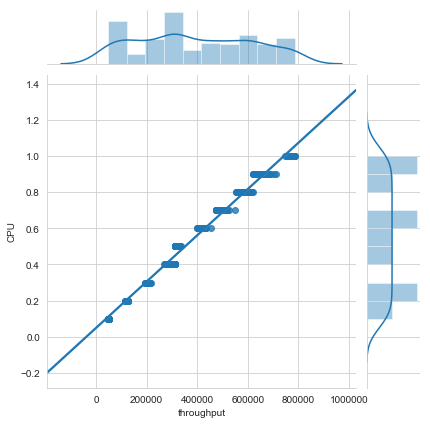

In [3]:
print(data.head())
print(data.describe())
sns.set_style('whitegrid')
sns.jointplot(x=data['throughput'],y=data['CPU'],kind="reg")

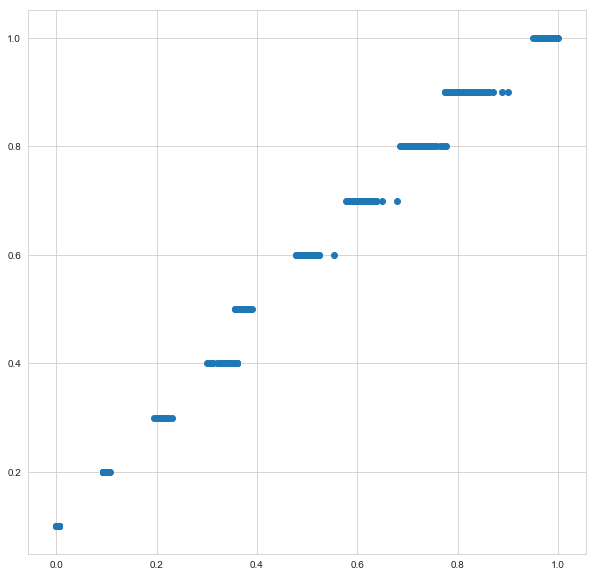

In [4]:
# #############################################################################
# Training and Testing Data
X = data[['throughput']]
y = data['CPU']
X = X.fillna(X.mean())

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

#Plot data
fig = plt.figure(figsize=(10, 10))
plt.scatter(X,y)
plt.show()

# Cross Validation Split
n = len(X)
kf = KFold(n_splits=5, shuffle=True)
fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [5]:
# #############################################################################
# Fit regression model
params = {'n_estimators': [50, 100, 200], 'max_depth':[2, 4, 6], 'min_samples_split': [2, 4, 12],
          'learning_rate': [0.1, 0.01, 0.001], 'loss': ['ls', 'lad', 'huber', 'quantile']}
gb = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gb, params, verbose=1, n_jobs=-1)

fit = clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   11.9s


{'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 12, 'n_estimators': 200}


[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   17.3s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [6]:
prediction = clf.predict(X_test)
y_test = np.array(list(y_test))
prediction= np.array(prediction)
df = pd.DataFrame({'Throuput':X_test.flatten(),'Actual': y_test.flatten(), 'Predicted': prediction.flatten()})


In [7]:
#Model Evaluation
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))
print('R^2:',metrics.r2_score(y_test, prediction))



MAE: 0.001256739305233239
MSE: 0.00012498577168869456
RMSE: 0.011179703559965021
R^2: 0.998271550943608


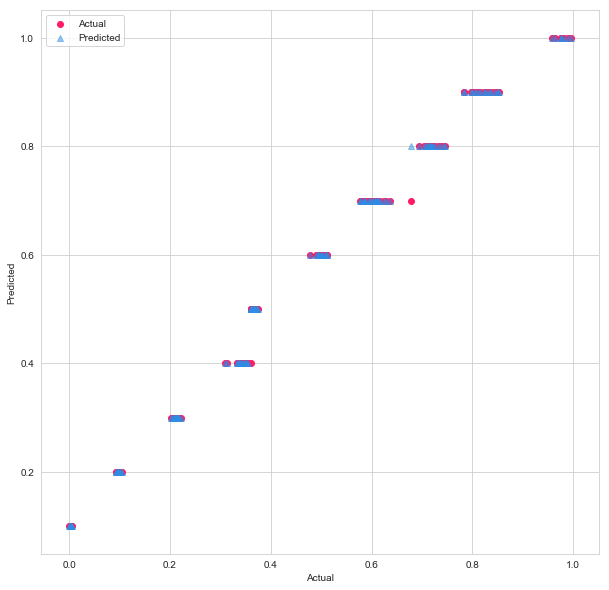

In [8]:
#Plot prediction
fig = plt.figure(figsize=(10, 10))

plt.scatter(X_test, y_test,  color='#fe1c64',label="Actual")
plt.scatter(X_test, prediction, color='#2e8de6', linewidth=1,marker='^',alpha = 0.5,label="Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


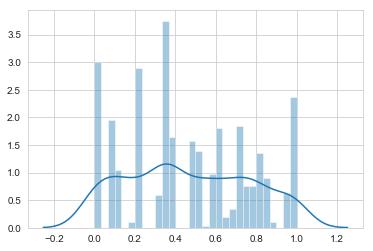

In [9]:
sns.distplot(X,bins=30)

In [10]:
# save the model to disk
filename = '../models/gradient_haproxy_big_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [11]:
data = scaler.transform(np.float32([[80]])) 
print(data)
clf.predict([[0.221934887]])

[[-0.0636106]]


array([0.30000359])